## Insights from results

### Insights from Visualization
- 

In [21]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [22]:
!cp -r ../input/indoorlocationgithub/* ./

In [23]:
from io_f import read_data_file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

In [24]:
SEED = 42

In [47]:
# train_file_name = "../input/indoorfulltestgroupedtrain/indoor_train_2_site_group.pkl"
# train_file_name = "../input/train3/indoor_train_3.pkl"
train_file_name = "../input/indoor2ndtrain/indoor_train_2.pkl"
test_file_name = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"
# dir_path = "../input/indoorpkl/"
# dir_path = "../input/indoorpkl/"

# Load data it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)
    
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df = sub_df.drop(columns=["floor", "x", "y"])

In [90]:
print(len(df_train))
display(df_train.head())
display(df_test.head())
display(sub_df.head())

553753


,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_500ms,within_1000ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,197.0,13.726707,22.423597,1.560916e+12,0.0,197.0,True,True,1.560916e+12,197.0,-0.215485,0.691925,9.414001,1.560916e+12,197.0,0.019111,-0.033138,-0.981493,1.560916e+12,197.0,-11.880000,-31.619999,-27.90,43.810601,1.560916e+12,197.0,-0.084213,0.018066,0.016937,1560916179027,197,0,0,9,1.560916e+12,197.0,16.380001,-32.94,-91.02,1560916179027,197,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179027000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
1,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,217.0,13.726707,22.423597,1.560916e+12,0.0,217.0,True,True,1.560916e+12,217.0,-0.287308,0.670380,9.540894,1.560916e+12,217.0,0.016971,-0.034242,-0.983516,1.560916e+12,217.0,-11.639999,-31.619999,-27.90,43.746130,1.560916e+12,217.0,-0.141205,0.004211,0.005219,1560916179047,217,0,0,9,1.560916e+12,217.0,16.620000,-32.94,-91.02,1560916179047,217,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179047000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
2,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,237.0,13.726707,22.423597,1.560916e+12,0.0,237.0,True,True,1.560916e+12,237.0,-0.265762,0.596161,9.758759,1.560916e+12,237.0,0.020993,-0.031925,-0.983147,1.560916e+12,237.0,-11.460000,-31.560000,-27.90,43.655185,1.560916e+12,237.0,-0.175827,0.001541,0.008942,1560916179067,237,0,0,9,1.560916e+12,237.0,16.800000,-32.88,-91.02,1560916179067,237,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179067000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
3,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,257.0,13.726707,22.423597,1.560916e+12,0.0,257.0,True,True,1.560916e+12,257.0,-0.179565,0.550659,9.844955,1.560916e+12,257.0,0.020695,-0.030332,-0.983186,1.560916e+12,257.0,-11.460000,-31.380000,-27.66,43.371783,1.560916e+12,257.0,-0.164642,0.031906,0.017471,1560916179087,257,0,0,9,1.560916e+12,257.0,16.800000,-32.70,-90.78,1560916179087,257,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.5609

,site_path_timestamp,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_250ms,within_500ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,136.0,0.0,136.0,NaN,NaN,9.0,9.0,127.0,False,True,136.0,136.0,0.798813,4.300720,7.810059,NaN,136.0,136.0,0.247101,0.104201,0.474897,NaN,136.0,136.0,30.561829,-1.228333,-38.301086,NaN,49.015379,136.0,136.0,-0.039139,-0.507996,-0.148392,NaN,136.0,136.0,0.578552,4.353989,8.195526,NaN,136.0,136.0,34.687805,6.938171,-377.32544,NaN,136.0,136.0,-0.077835,-0.334671,-0.166565,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.136,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,156.0,0.0,156.0,NaN,NaN,9.0,9.0,147.0,False,True,156.0,156.0,0.026688,4.911835,7.244446,NaN,156.0,156.0,0.247101,0.104201,0.474897,NaN,156.0,156.0,29.173279,-1.922607,-36.950684,NaN,47.118252,156.0,156.0,-0.084946,-0.447800,-0.207520,NaN,156.0,156.0,0.524673,4.493454,7.438370,NaN,156.0,156.0,33.299255,6.243896,-375.97504,NaN,156.0,156.0,-0.049072,-0.504059,-0.155380,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.156,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,176.0,0.0,176.0,NaN,NaN,9.0,9.0,167.0,False,True,176.0,176.0,-0.418640,5.354172,7.295914,NaN,176.0,176.0,0.254368,0.111510,0.452041,NaN,176.0,176.0,27.786255,-0.535583,-37.625122,NaN,46.776197,176.0,176.0,-0.110519,-0.327423,-0.163315,NaN,176.0,176.0,-0.269592,5.217697,7.327042,NaN,176.0,176.0,31.912231,7.630920,-376.64948,NaN,176.0,176.0,-0.094879,-0.443863,-0.214508,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,216.0,216.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.176,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,196.0,0.0,196.0,NaN,NaN,9.0,9.0,187.0,False,True,196.0,196.0,-0.540146,5.456512,7.113358,NaN,196.0,196.0,0.254368,0.111510,0.452041,NaN,196.0,196.0,27.786255,-0.535583,-36.950684,NaN,46.235439,196.0,196.0,-0.267639,-0.278961,-0.078094,NaN,196.0,196.0,-0.555710,5.455322,7.103775,NaN,196.0,196.0,31.912231,7.630920,-375.97504,NaN,196.0,196.0,-0.120453,-0.323486,-0.170303,NaN,2340

,site_path_timestamp,site,file,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328


In [27]:
# # set the index for test data
# df_test = df_test.set_index("site_path_timestamp")
# display(df_test.head())

In [48]:
# Train info
print("df len: ", len(df_train), "\n")
print("df column len: ", len(df_train.columns), "\n")
print("site_id nunique: ", df_train["site_id"].nunique(), "\n")
print("file_id nunique: ", df_train["file_id"].nunique(), "\n")
#print("floor value_counts: ", df_train["floor"].value_counts(), "\n")
print("x nunique: ", df_train["x"].nunique(), "\n")
print("y nunique: ", df_train["y"].nunique(), "\n")
print("event ts nunique: ", df_train["ts"].nunique(), "\n")
print("start ts nunique: ", df_train["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts nunique: ", df_train["diff_ts_wp_ts"].nunique(), "\n")

df len:  553753 

df column len:  86 

site_id nunique:  10 

file_id nunique:  961 

x nunique:  2514 

y nunique:  2514 

event ts nunique:  553651 

start ts nunique:  961 

diff_ts_wp_ts nunique:  1999 



In [29]:
# # Test info
# print("df len: ", len(df_test), "\n")
# print("df column len: ", len(df_test.columns), "\n")
# print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
# print("file_id nunique: ", df_test["file_id"].nunique(), "\n")
# print("x nunique: ", df_test["x"].nunique(), "\n")
# print("y nunique: ", df_test["y"].nunique(), "\n")
# print("event ts nunique: ", df_test["ts"].nunique(), "\n")
# print("start ts nunique: ", df_test["start_ts"].nunique(), "\n") # should be same length as file_id
# print("diff_ts_wp_ts nunique: ", df_test["diff_ts_wp_ts"].nunique(), "\n")

In [30]:
# test_site_id = df_test["site_id"].unique()
# train_site_id = df_train["site_id"].unique()
# print(test_site_id, "\n")
# print(train_site_id, "\n")
# a = list(set(test_site_id) & set(train_site_id))
# print(len(a))

In [31]:
# # print("test_df site_id value_counts: ", df_test["file_id"].value_counts(), "\n")
# # print("sub_df site_id value_counts: ", sub_df["file"].value_counts(), "\n")

# # Matching sites: 5d2709d403f801723c32bd39, 5dc8cea7659e181adb076a3f, 5d2709b303f801723c327472
# # Missing sites: 5dbc1d84c1eb61796cf7c010, 5da958dd46f8266d0737457b, 5d2709bb03f801723c32852c, 5d27096c03f801723c31e5e0

# # Matching files: f4bd7479dbe91f3d18f44c49, 4affd104e0ec7a7806edfa78, 610f2c07b26508790d1cd355
# # Missing files: d72ceac4628436a540910d98, 2b4bacedc942ffcb523ff20f, 876cd27fc8f63a2800fc3de8
# base_path = "../input/indoor-location-navigation/test/"
# match_path = "4affd104e0ec7a7806edfa78"
# missing_path = "d72ceac4628436a540910d98"

# match_path_full = base_path + match_path + ".txt"
# missing_path_full = base_path + missing_path + ".txt"

# #timestamps in sub_df
# sub_df_a = sub_df[sub_df["file"] == match_path]
# sub_df_a_ts = sorted(sub_df_a["timestamp"].value_counts().keys())
# print(sub_df_a_ts[0])
# df_test_match = df_test[(df_test["file_id"] == match_path) & (df_test["closest_wp_ts"] == int(sub_df_a_ts[0]))]
# display(df_test_match.head())

# sub_df_b = sub_df[sub_df["file"] == missing_path]
# sub_df_b_ts = sorted(sub_df_b["timestamp"].value_counts().keys())
# # display(sub_df_b.head())

# # ts for submission files
# print(sub_df_a_ts[:5], "\n")
# print(sub_df_b_ts[:5])

In [58]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [49]:
print(len(df_train.columns))
df_train = df_train.dropna(axis=1, how='all')
df_train = df_train.dropna(axis=0, how='any')
print(len(df_train.columns))

null_cols = df_train.columns[df_train.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_train, tqdm(null_cols), "site_id")

# null_cols = df_train.columns[df_train.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)

86
78
Columns with nulls:  []


In [50]:
# column settings

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
# categorical_features = ["site_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
categorical_features = ["site_id", "within_500ms", "within_1000ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["floor_converted", "acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_train[col] = df_train[col].astype(int)

In [51]:
# print(df_train.dtypes[:50])
display(df_train.head())

,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_500ms,within_1000ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,197.0,13.726707,22.423597,1.560916e+12,0.0,197.0,True,True,1.560916e+12,197.0,-0.215485,0.691925,9.414001,1.560916e+12,197.0,0.019111,-0.033138,-0.981493,1.560916e+12,197.0,-11.880000,-31.619999,-27.90,43.810601,1.560916e+12,197.0,-0.084213,0.018066,0.016937,1560916179027,197,0,0,9,1.560916e+12,197.0,16.380001,-32.94,-91.02,1560916179027,197,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179027000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
1,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,217.0,13.726707,22.423597,1.560916e+12,0.0,217.0,True,True,1.560916e+12,217.0,-0.287308,0.670380,9.540894,1.560916e+12,217.0,0.016971,-0.034242,-0.983516,1.560916e+12,217.0,-11.639999,-31.619999,-27.90,43.746130,1.560916e+12,217.0,-0.141205,0.004211,0.005219,1560916179047,217,0,0,9,1.560916e+12,217.0,16.620000,-32.94,-91.02,1560916179047,217,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179047000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
2,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,237.0,13.726707,22.423597,1.560916e+12,0.0,237.0,True,True,1.560916e+12,237.0,-0.265762,0.596161,9.758759,1.560916e+12,237.0,0.020993,-0.031925,-0.983147,1.560916e+12,237.0,-11.460000,-31.560000,-27.90,43.655185,1.560916e+12,237.0,-0.175827,0.001541,0.008942,1560916179067,237,0,0,9,1.560916e+12,237.0,16.800000,-32.88,-91.02,1560916179067,237,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.560916e+12,1683.0,0.171185,-0.403686,4,238,4,338,552,1007,1560916179067000064,1560902400000000000,1560913200000000000,1560916140000000000,1560916166728000000,1560902400000000000,1560913200000000000,1560916140000000000
3,5cd56c0ce2acfd2d33b6ab27,5d09b23fcfb49b00085466aa,2,F3,1.560916e+12,1.560916e+12,257.0,13.726707,22.423597,1.560916e+12,0.0,257.0,True,True,1.560916e+12,257.0,-0.179565,0.550659,9.844955,1.560916e+12,257.0,0.020695,-0.030332,-0.983186,1.560916e+12,257.0,-11.460000,-31.380000,-27.66,43.371783,1.560916e+12,257.0,-0.164642,0.031906,0.017471,1560916179087,257,0,0,9,1.560916e+12,257.0,16.800000,-32.70,-90.78,1560916179087,257,0,0,0,1560916179432,602,b1e32753c8cfd3624253d16d9bc944d917c451e4,8760dd3789b36258dea5d2b3687be70eb2163310,-77,1560916166728,1560916180806,1976,bd1b5cf6d9f4f7bcb796b62cc831b6c81b1aa6ae_356a1...,-97,1.5609

In [52]:
# dataset prep for training
target_x = df_train.iloc[:, 7]
target_y = df_train.iloc[:, 8]
target_f = df_train.iloc[:, 2]

# drop target columns
# drop_cols = ["file_id", "floor_converted", "floor", "x", "y", "floor_le"]
drop_cols = ["file_id", "floor_converted", "floor", "x", "y"]
features = df_train.drop(columns=drop_cols)

# set target cols
targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = SEED)
    feat_train, feat_viz, target_train, target_viz = \
    train_test_split(feat_train, target_train, test_size = 0.2, random_state = SEED)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["feat_viz_{}".format(tgt)] = feat_viz
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["target_viz_{}".format(tgt)] = target_viz
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["feat_viz_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["target_viz_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

(354401, 73)
(110751, 73)
(88601, 73)
(354401,)
(110751,)
(88601,)
(354401, 73)
(354401,)
(110751, 73)
(110751,)
(354401, 73)
(110751, 73)
(88601, 73)
(354401,)
(110751,)
(88601,)
(354401, 73)
(354401,)
(110751, 73)
(110751,)
(354401, 73)
(110751, 73)
(88601, 73)
(354401,)
(110751,)
(88601,)
(354401, 73)
(354401,)
(110751, 73)
(110751,)


In [53]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 2000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 10,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15959
[LightGBM] [Info] Number of data points in the train set: 354401, number of used features: 72


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 73.260932
[1]	valid_0's rmse: 41.8729
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 38.748
[3]	valid_0's rmse: 35.6586
[4]	valid_0's rmse: 32.863
[5]	valid_0's rmse: 30.2047
[6]	valid_0's rmse: 27.8686
[7]	valid_0's rmse: 25.716
[8]	valid_0's rmse: 23.9196
[9]	valid_0's rmse: 22.2218
[10]	valid_0's rmse: 20.7099
[11]	valid_0's rmse: 19.4212
[12]	valid_0's rmse: 18.321
[13]	valid_0's rmse: 17.2089
[14]	valid_0's rmse: 16.2644
[15]	valid_0's rmse: 15.4018
[16]	valid_0's rmse: 14.7015
[17]	valid_0's rmse: 14.007
[18]	valid_0's rmse: 13.425
[19]	valid_0's rmse: 12.8721
[20]	valid_0's rmse: 12.3189
[21]	valid_0's rmse: 11.8714
[22]	valid_0's rmse: 11.4998
[23]	valid_0's rmse: 11.2125
[24]	valid_0's rmse: 10.8742
[25]	valid_0's rmse: 10.5716
[26]	valid_0's rmse: 10.2973
[27]	valid_0's rmse: 10.0578
[28]	valid_0's rmse: 9.85371
[29]	valid_0's rmse: 9.62062
[30]	valid_0's rmse: 9.4215
[31]	valid_0's rmse: 9.25575
[3

[277]	valid_0's rmse: 3.38459
[278]	valid_0's rmse: 3.3787
[279]	valid_0's rmse: 3.37291
[280]	valid_0's rmse: 3.36583
[281]	valid_0's rmse: 3.35608
[282]	valid_0's rmse: 3.35022
[283]	valid_0's rmse: 3.34352
[284]	valid_0's rmse: 3.33353
[285]	valid_0's rmse: 3.3284
[286]	valid_0's rmse: 3.32118
[287]	valid_0's rmse: 3.31341
[288]	valid_0's rmse: 3.30276
[289]	valid_0's rmse: 3.29333
[290]	valid_0's rmse: 3.28936
[291]	valid_0's rmse: 3.28453
[292]	valid_0's rmse: 3.27885
[293]	valid_0's rmse: 3.27242
[294]	valid_0's rmse: 3.26658
[295]	valid_0's rmse: 3.26088
[296]	valid_0's rmse: 3.25338
[297]	valid_0's rmse: 3.2497
[298]	valid_0's rmse: 3.24617
[299]	valid_0's rmse: 3.24035
[300]	valid_0's rmse: 3.2343
[301]	valid_0's rmse: 3.22925
[302]	valid_0's rmse: 3.22465
[303]	valid_0's rmse: 3.21743
[304]	valid_0's rmse: 3.21248
[305]	valid_0's rmse: 3.20436
[306]	valid_0's rmse: 3.20004
[307]	valid_0's rmse: 3.19633
[308]	valid_0's rmse: 3.19297
[309]	valid_0's rmse: 3.18949
[310]	valid_0'

[554]	valid_0's rmse: 2.2116
[555]	valid_0's rmse: 2.20894
[556]	valid_0's rmse: 2.20708
[557]	valid_0's rmse: 2.20344
[558]	valid_0's rmse: 2.19785
[559]	valid_0's rmse: 2.19526
[560]	valid_0's rmse: 2.19365
[561]	valid_0's rmse: 2.19209
[562]	valid_0's rmse: 2.18839
[563]	valid_0's rmse: 2.18646
[564]	valid_0's rmse: 2.18351
[565]	valid_0's rmse: 2.18185
[566]	valid_0's rmse: 2.17975
[567]	valid_0's rmse: 2.17788
[568]	valid_0's rmse: 2.17561
[569]	valid_0's rmse: 2.17263
[570]	valid_0's rmse: 2.17072
[571]	valid_0's rmse: 2.16861
[572]	valid_0's rmse: 2.16432
[573]	valid_0's rmse: 2.16179
[574]	valid_0's rmse: 2.15992
[575]	valid_0's rmse: 2.15776
[576]	valid_0's rmse: 2.15572
[577]	valid_0's rmse: 2.15342
[578]	valid_0's rmse: 2.15211
[579]	valid_0's rmse: 2.15023
[580]	valid_0's rmse: 2.14849
[581]	valid_0's rmse: 2.14666
[582]	valid_0's rmse: 2.14444
[583]	valid_0's rmse: 2.1427
[584]	valid_0's rmse: 2.14017
[585]	valid_0's rmse: 2.138
[586]	valid_0's rmse: 2.13611
[587]	valid_0'

[832]	valid_0's rmse: 1.69649
[833]	valid_0's rmse: 1.69563
[834]	valid_0's rmse: 1.69489
[835]	valid_0's rmse: 1.69401
[836]	valid_0's rmse: 1.69321
[837]	valid_0's rmse: 1.69197
[838]	valid_0's rmse: 1.69086
[839]	valid_0's rmse: 1.68995
[840]	valid_0's rmse: 1.68859
[841]	valid_0's rmse: 1.68777
[842]	valid_0's rmse: 1.68688
[843]	valid_0's rmse: 1.68577
[844]	valid_0's rmse: 1.68518
[845]	valid_0's rmse: 1.6841
[846]	valid_0's rmse: 1.68336
[847]	valid_0's rmse: 1.68132
[848]	valid_0's rmse: 1.68031
[849]	valid_0's rmse: 1.67947
[850]	valid_0's rmse: 1.67848
[851]	valid_0's rmse: 1.67683
[852]	valid_0's rmse: 1.67615
[853]	valid_0's rmse: 1.67515
[854]	valid_0's rmse: 1.6742
[855]	valid_0's rmse: 1.67318
[856]	valid_0's rmse: 1.67201
[857]	valid_0's rmse: 1.67092
[858]	valid_0's rmse: 1.66879
[859]	valid_0's rmse: 1.66764
[860]	valid_0's rmse: 1.66595
[861]	valid_0's rmse: 1.66529
[862]	valid_0's rmse: 1.66324
[863]	valid_0's rmse: 1.66184
[864]	valid_0's rmse: 1.66094
[865]	valid_

[1103]	valid_0's rmse: 1.42858
[1104]	valid_0's rmse: 1.42813
[1105]	valid_0's rmse: 1.427
[1106]	valid_0's rmse: 1.42653
[1107]	valid_0's rmse: 1.42581
[1108]	valid_0's rmse: 1.42529
[1109]	valid_0's rmse: 1.42392
[1110]	valid_0's rmse: 1.42319
[1111]	valid_0's rmse: 1.4224
[1112]	valid_0's rmse: 1.4218
[1113]	valid_0's rmse: 1.4212
[1114]	valid_0's rmse: 1.42018
[1115]	valid_0's rmse: 1.41892
[1116]	valid_0's rmse: 1.41792
[1117]	valid_0's rmse: 1.41723
[1118]	valid_0's rmse: 1.41673
[1119]	valid_0's rmse: 1.41612
[1120]	valid_0's rmse: 1.41555
[1121]	valid_0's rmse: 1.41482
[1122]	valid_0's rmse: 1.41437
[1123]	valid_0's rmse: 1.41381
[1124]	valid_0's rmse: 1.41322
[1125]	valid_0's rmse: 1.41245
[1126]	valid_0's rmse: 1.41142
[1127]	valid_0's rmse: 1.41051
[1128]	valid_0's rmse: 1.40982
[1129]	valid_0's rmse: 1.40939
[1130]	valid_0's rmse: 1.40887
[1131]	valid_0's rmse: 1.40842
[1132]	valid_0's rmse: 1.40726
[1133]	valid_0's rmse: 1.40623
[1134]	valid_0's rmse: 1.40513
[1135]	valid_

[1373]	valid_0's rmse: 1.25248
[1374]	valid_0's rmse: 1.25206
[1375]	valid_0's rmse: 1.25173
[1376]	valid_0's rmse: 1.25123
[1377]	valid_0's rmse: 1.25041
[1378]	valid_0's rmse: 1.24982
[1379]	valid_0's rmse: 1.24949
[1380]	valid_0's rmse: 1.24891
[1381]	valid_0's rmse: 1.24805
[1382]	valid_0's rmse: 1.24761
[1383]	valid_0's rmse: 1.24685
[1384]	valid_0's rmse: 1.24652
[1385]	valid_0's rmse: 1.24585
[1386]	valid_0's rmse: 1.24547
[1387]	valid_0's rmse: 1.24504
[1388]	valid_0's rmse: 1.24453
[1389]	valid_0's rmse: 1.24422
[1390]	valid_0's rmse: 1.24385
[1391]	valid_0's rmse: 1.24348
[1392]	valid_0's rmse: 1.24308
[1393]	valid_0's rmse: 1.2428
[1394]	valid_0's rmse: 1.24213
[1395]	valid_0's rmse: 1.24156
[1396]	valid_0's rmse: 1.24087
[1397]	valid_0's rmse: 1.24028
[1398]	valid_0's rmse: 1.23987
[1399]	valid_0's rmse: 1.23944
[1400]	valid_0's rmse: 1.23868
[1401]	valid_0's rmse: 1.23843
[1402]	valid_0's rmse: 1.23774
[1403]	valid_0's rmse: 1.23732
[1404]	valid_0's rmse: 1.23668
[1405]	va

[1642]	valid_0's rmse: 1.13139
[1643]	valid_0's rmse: 1.13069
[1644]	valid_0's rmse: 1.13026
[1645]	valid_0's rmse: 1.12993
[1646]	valid_0's rmse: 1.12963
[1647]	valid_0's rmse: 1.12929
[1648]	valid_0's rmse: 1.12885
[1649]	valid_0's rmse: 1.12815
[1650]	valid_0's rmse: 1.12789
[1651]	valid_0's rmse: 1.12769
[1652]	valid_0's rmse: 1.12725
[1653]	valid_0's rmse: 1.12692
[1654]	valid_0's rmse: 1.12659
[1655]	valid_0's rmse: 1.12627
[1656]	valid_0's rmse: 1.12608
[1657]	valid_0's rmse: 1.12589
[1658]	valid_0's rmse: 1.12552
[1659]	valid_0's rmse: 1.12488
[1660]	valid_0's rmse: 1.12456
[1661]	valid_0's rmse: 1.12431
[1662]	valid_0's rmse: 1.12408
[1663]	valid_0's rmse: 1.12375
[1664]	valid_0's rmse: 1.12358
[1665]	valid_0's rmse: 1.12299
[1666]	valid_0's rmse: 1.12265
[1667]	valid_0's rmse: 1.12231
[1668]	valid_0's rmse: 1.12202
[1669]	valid_0's rmse: 1.12185
[1670]	valid_0's rmse: 1.1216
[1671]	valid_0's rmse: 1.12114
[1672]	valid_0's rmse: 1.12087
[1673]	valid_0's rmse: 1.12053
[1674]	va

[1909]	valid_0's rmse: 1.04661
[1910]	valid_0's rmse: 1.04641
[1911]	valid_0's rmse: 1.04615
[1912]	valid_0's rmse: 1.04599
[1913]	valid_0's rmse: 1.04581
[1914]	valid_0's rmse: 1.04532
[1915]	valid_0's rmse: 1.04498
[1916]	valid_0's rmse: 1.04454
[1917]	valid_0's rmse: 1.04437
[1918]	valid_0's rmse: 1.04411
[1919]	valid_0's rmse: 1.04387
[1920]	valid_0's rmse: 1.04372
[1921]	valid_0's rmse: 1.04356
[1922]	valid_0's rmse: 1.04345
[1923]	valid_0's rmse: 1.04321
[1924]	valid_0's rmse: 1.04302
[1925]	valid_0's rmse: 1.04283
[1926]	valid_0's rmse: 1.04239
[1927]	valid_0's rmse: 1.04217
[1928]	valid_0's rmse: 1.04186
[1929]	valid_0's rmse: 1.04168
[1930]	valid_0's rmse: 1.04143
[1931]	valid_0's rmse: 1.04121
[1932]	valid_0's rmse: 1.04107
[1933]	valid_0's rmse: 1.04083
[1934]	valid_0's rmse: 1.04009
[1935]	valid_0's rmse: 1.03977
[1936]	valid_0's rmse: 1.03959
[1937]	valid_0's rmse: 1.03946
[1938]	valid_0's rmse: 1.03925
[1939]	valid_0's rmse: 1.03902
[1940]	valid_0's rmse: 1.03883
[1941]	v

[169]	valid_0's rmse: 4.67731
[170]	valid_0's rmse: 4.66773
[171]	valid_0's rmse: 4.65362
[172]	valid_0's rmse: 4.64424
[173]	valid_0's rmse: 4.6322
[174]	valid_0's rmse: 4.6203
[175]	valid_0's rmse: 4.6066
[176]	valid_0's rmse: 4.59851
[177]	valid_0's rmse: 4.59056
[178]	valid_0's rmse: 4.57955
[179]	valid_0's rmse: 4.56726
[180]	valid_0's rmse: 4.56023
[181]	valid_0's rmse: 4.54998
[182]	valid_0's rmse: 4.53953
[183]	valid_0's rmse: 4.5257
[184]	valid_0's rmse: 4.51326
[185]	valid_0's rmse: 4.50294
[186]	valid_0's rmse: 4.49218
[187]	valid_0's rmse: 4.47999
[188]	valid_0's rmse: 4.46991
[189]	valid_0's rmse: 4.45996
[190]	valid_0's rmse: 4.45091
[191]	valid_0's rmse: 4.43616
[192]	valid_0's rmse: 4.42721
[193]	valid_0's rmse: 4.41915
[194]	valid_0's rmse: 4.41089
[195]	valid_0's rmse: 4.4006
[196]	valid_0's rmse: 4.39326
[197]	valid_0's rmse: 4.38381
[198]	valid_0's rmse: 4.37335
[199]	valid_0's rmse: 4.36297
[200]	valid_0's rmse: 4.35385
[201]	valid_0's rmse: 4.34612
[202]	valid_0's

[444]	valid_0's rmse: 2.86935
[445]	valid_0's rmse: 2.86573
[446]	valid_0's rmse: 2.86072
[447]	valid_0's rmse: 2.85764
[448]	valid_0's rmse: 2.85311
[449]	valid_0's rmse: 2.84617
[450]	valid_0's rmse: 2.84255
[451]	valid_0's rmse: 2.83928
[452]	valid_0's rmse: 2.83583
[453]	valid_0's rmse: 2.8322
[454]	valid_0's rmse: 2.82886
[455]	valid_0's rmse: 2.82464
[456]	valid_0's rmse: 2.81943
[457]	valid_0's rmse: 2.81426
[458]	valid_0's rmse: 2.81054
[459]	valid_0's rmse: 2.80784
[460]	valid_0's rmse: 2.80492
[461]	valid_0's rmse: 2.80228
[462]	valid_0's rmse: 2.79922
[463]	valid_0's rmse: 2.79722
[464]	valid_0's rmse: 2.79475
[465]	valid_0's rmse: 2.79193
[466]	valid_0's rmse: 2.78877
[467]	valid_0's rmse: 2.787
[468]	valid_0's rmse: 2.78443
[469]	valid_0's rmse: 2.78207
[470]	valid_0's rmse: 2.77971
[471]	valid_0's rmse: 2.77572
[472]	valid_0's rmse: 2.77233
[473]	valid_0's rmse: 2.76934
[474]	valid_0's rmse: 2.76633
[475]	valid_0's rmse: 2.76377
[476]	valid_0's rmse: 2.76146
[477]	valid_0

[719]	valid_0's rmse: 2.14805
[720]	valid_0's rmse: 2.14527
[721]	valid_0's rmse: 2.14383
[722]	valid_0's rmse: 2.14224
[723]	valid_0's rmse: 2.14044
[724]	valid_0's rmse: 2.13856
[725]	valid_0's rmse: 2.13749
[726]	valid_0's rmse: 2.13645
[727]	valid_0's rmse: 2.13405
[728]	valid_0's rmse: 2.13246
[729]	valid_0's rmse: 2.13102
[730]	valid_0's rmse: 2.12969
[731]	valid_0's rmse: 2.12804
[732]	valid_0's rmse: 2.12602
[733]	valid_0's rmse: 2.12454
[734]	valid_0's rmse: 2.12244
[735]	valid_0's rmse: 2.1207
[736]	valid_0's rmse: 2.11918
[737]	valid_0's rmse: 2.11687
[738]	valid_0's rmse: 2.11495
[739]	valid_0's rmse: 2.11342
[740]	valid_0's rmse: 2.11196
[741]	valid_0's rmse: 2.11023
[742]	valid_0's rmse: 2.10849
[743]	valid_0's rmse: 2.10572
[744]	valid_0's rmse: 2.10432
[745]	valid_0's rmse: 2.10294
[746]	valid_0's rmse: 2.10159
[747]	valid_0's rmse: 2.09865
[748]	valid_0's rmse: 2.09638
[749]	valid_0's rmse: 2.09453
[750]	valid_0's rmse: 2.09305
[751]	valid_0's rmse: 2.09174
[752]	valid

[996]	valid_0's rmse: 1.73736
[997]	valid_0's rmse: 1.73607
[998]	valid_0's rmse: 1.73512
[999]	valid_0's rmse: 1.73308
[1000]	valid_0's rmse: 1.73199
[1001]	valid_0's rmse: 1.73114
[1002]	valid_0's rmse: 1.73022
[1003]	valid_0's rmse: 1.72927
[1004]	valid_0's rmse: 1.72872
[1005]	valid_0's rmse: 1.72739
[1006]	valid_0's rmse: 1.72543
[1007]	valid_0's rmse: 1.72409
[1008]	valid_0's rmse: 1.72297
[1009]	valid_0's rmse: 1.72216
[1010]	valid_0's rmse: 1.72119
[1011]	valid_0's rmse: 1.72049
[1012]	valid_0's rmse: 1.71996
[1013]	valid_0's rmse: 1.71861
[1014]	valid_0's rmse: 1.71745
[1015]	valid_0's rmse: 1.71566
[1016]	valid_0's rmse: 1.71452
[1017]	valid_0's rmse: 1.71374
[1018]	valid_0's rmse: 1.71277
[1019]	valid_0's rmse: 1.71167
[1020]	valid_0's rmse: 1.71078
[1021]	valid_0's rmse: 1.70825
[1022]	valid_0's rmse: 1.7071
[1023]	valid_0's rmse: 1.70596
[1024]	valid_0's rmse: 1.70511
[1025]	valid_0's rmse: 1.70276
[1026]	valid_0's rmse: 1.70149
[1027]	valid_0's rmse: 1.70023
[1028]	valid_

[1267]	valid_0's rmse: 1.48834
[1268]	valid_0's rmse: 1.48779
[1269]	valid_0's rmse: 1.48708
[1270]	valid_0's rmse: 1.48601
[1271]	valid_0's rmse: 1.48546
[1272]	valid_0's rmse: 1.4846
[1273]	valid_0's rmse: 1.48388
[1274]	valid_0's rmse: 1.48291
[1275]	valid_0's rmse: 1.4824
[1276]	valid_0's rmse: 1.48025
[1277]	valid_0's rmse: 1.47971
[1278]	valid_0's rmse: 1.47928
[1279]	valid_0's rmse: 1.47868
[1280]	valid_0's rmse: 1.47796
[1281]	valid_0's rmse: 1.47688
[1282]	valid_0's rmse: 1.47606
[1283]	valid_0's rmse: 1.47556
[1284]	valid_0's rmse: 1.47483
[1285]	valid_0's rmse: 1.47435
[1286]	valid_0's rmse: 1.47384
[1287]	valid_0's rmse: 1.47316
[1288]	valid_0's rmse: 1.4727
[1289]	valid_0's rmse: 1.47186
[1290]	valid_0's rmse: 1.47141
[1291]	valid_0's rmse: 1.47096
[1292]	valid_0's rmse: 1.47005
[1293]	valid_0's rmse: 1.46941
[1294]	valid_0's rmse: 1.46872
[1295]	valid_0's rmse: 1.46792
[1296]	valid_0's rmse: 1.46731
[1297]	valid_0's rmse: 1.46653
[1298]	valid_0's rmse: 1.46583
[1299]	vali

[1535]	valid_0's rmse: 1.32514
[1536]	valid_0's rmse: 1.32456
[1537]	valid_0's rmse: 1.3241
[1538]	valid_0's rmse: 1.32381
[1539]	valid_0's rmse: 1.32323
[1540]	valid_0's rmse: 1.32279
[1541]	valid_0's rmse: 1.32239
[1542]	valid_0's rmse: 1.32196
[1543]	valid_0's rmse: 1.32164
[1544]	valid_0's rmse: 1.32125
[1545]	valid_0's rmse: 1.32071
[1546]	valid_0's rmse: 1.32043
[1547]	valid_0's rmse: 1.32009
[1548]	valid_0's rmse: 1.3195
[1549]	valid_0's rmse: 1.31904
[1550]	valid_0's rmse: 1.31871
[1551]	valid_0's rmse: 1.3182
[1552]	valid_0's rmse: 1.3178
[1553]	valid_0's rmse: 1.31745
[1554]	valid_0's rmse: 1.31701
[1555]	valid_0's rmse: 1.31651
[1556]	valid_0's rmse: 1.31608
[1557]	valid_0's rmse: 1.31549
[1558]	valid_0's rmse: 1.31515
[1559]	valid_0's rmse: 1.31486
[1560]	valid_0's rmse: 1.3145
[1561]	valid_0's rmse: 1.31394
[1562]	valid_0's rmse: 1.31324
[1563]	valid_0's rmse: 1.31296
[1564]	valid_0's rmse: 1.31255
[1565]	valid_0's rmse: 1.31229
[1566]	valid_0's rmse: 1.31193
[1567]	valid_

[1803]	valid_0's rmse: 1.20931
[1804]	valid_0's rmse: 1.20901
[1805]	valid_0's rmse: 1.20872
[1806]	valid_0's rmse: 1.20833
[1807]	valid_0's rmse: 1.2077
[1808]	valid_0's rmse: 1.20751
[1809]	valid_0's rmse: 1.2072
[1810]	valid_0's rmse: 1.20615
[1811]	valid_0's rmse: 1.20548
[1812]	valid_0's rmse: 1.205
[1813]	valid_0's rmse: 1.20471
[1814]	valid_0's rmse: 1.20428
[1815]	valid_0's rmse: 1.20398
[1816]	valid_0's rmse: 1.20325
[1817]	valid_0's rmse: 1.20279
[1818]	valid_0's rmse: 1.20225
[1819]	valid_0's rmse: 1.20173
[1820]	valid_0's rmse: 1.20154
[1821]	valid_0's rmse: 1.20123
[1822]	valid_0's rmse: 1.20103
[1823]	valid_0's rmse: 1.20081
[1824]	valid_0's rmse: 1.20048
[1825]	valid_0's rmse: 1.20028
[1826]	valid_0's rmse: 1.2
[1827]	valid_0's rmse: 1.19973
[1828]	valid_0's rmse: 1.19946
[1829]	valid_0's rmse: 1.19917
[1830]	valid_0's rmse: 1.19898
[1831]	valid_0's rmse: 1.19858
[1832]	valid_0's rmse: 1.19827
[1833]	valid_0's rmse: 1.19797
[1834]	valid_0's rmse: 1.19775
[1835]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's rmse: 0.154316
[24]	valid_0's rmse: 0.141247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	valid_0's rmse: 0.128635
[26]	valid_0's rmse: 0.118845
[27]	valid_0's rmse: 0.109425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's rmse: 0.100536
[29]	valid_0's rmse: 0.0929879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's rmse: 0.0869511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's rmse: 0.0808235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's rmse: 0.0756553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's rmse: 0.0711117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's rmse: 0.0671087
[35]	valid_0's rmse: 0.0625919
[36

[229]	valid_0's rmse: 0.013595
[230]	valid_0's rmse: 0.0135492
[231]	valid_0's rmse: 0.0135242
[232]	valid_0's rmse: 0.0135161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's rmse: 0.013513
[234]	valid_0's rmse: 0.0134969
[235]	valid_0's rmse: 0.0134455
[236]	valid_0's rmse: 0.0134357
[237]	valid_0's rmse: 0.0134141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 0.0133913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 0.0133869
[240]	valid_0's rmse: 0.013377
[241]	valid_0's rmse: 0.0133362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 0.0133319
[243]	valid_0's rmse: 0.013304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 0.0133007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's rmse: 0.0132972
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 0.0120954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 0.0120935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's rmse: 0.0120914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's rmse: 0.0120887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's rmse: 0.0120887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[332]	valid_0's rmse: 0.0120834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's rmse: 0.0120821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[334]	valid_0's rmse: 0.0120768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's rmse: 0.0120712
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 0.0113694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 0.0113682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 0.0113681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 0.011368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 0.0113666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 0.0113648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 0.0113592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 0.0113559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's rmse: 0.011353
[LightGBM] [Warning] No further splits 

[484]	valid_0's rmse: 0.011094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's rmse: 0.0110899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's rmse: 0.0110707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's rmse: 0.0110673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 0.011067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 0.0110398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[490]	valid_0's rmse: 0.0110398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[491]	valid_0's rmse: 0.0110398
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[555]	valid_0's rmse: 0.0108381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[556]	valid_0's rmse: 0.0108381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[557]	valid_0's rmse: 0.0108376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's rmse: 0.0108371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[559]	valid_0's rmse: 0.0108369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[560]	valid_0's rmse: 0.0108367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[561]	valid_0's rmse: 0.0108352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[562]	valid_0's rmse: 0.0108336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's rmse: 0.0108314
[LightGBM] [Warning] No further split

In [54]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'feat_viz_x', 'target_train_x', 'target_val_x', 'target_viz_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'feat_viz_y', 'target_train_y', 'target_val_y', 'target_viz_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'feat_viz_f', 'target_train_f', 'target_val_f', 'target_viz_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
110751
110751


In [55]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 1.023090175685378 rmse_y: 1.146489275806331 rmse_f: 0.010822717274466024


In [59]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = np.array(d["target_val_f"]).astype(float)
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"],
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
comp metric:  1.0798361014763371


In [ ]:
# lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))
# lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))
# lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

---
## Use the trained model to predict viz data
---

In [75]:
# Run prediction against train data
print(d["feat_viz_x"].shape)
print(d["feat_viz_y"].shape)
print(d["target_viz_x"].shape)

(88601, 73)
(88601, 73)
(88601,)


In [76]:
# Make predictions using the viz data
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
viz_predsx = modelx.predict(d["feat_viz_x"])
viz_predsy = modely.predict(d["feat_viz_y"])
viz_predsf = modelf.predict(d["feat_viz_f"])

In [131]:
# quick check
# overlap_check = set(d["feat_viz_x"].index) ^ set(d["feat_viz_f"].index)
# print(overlap_check)

df_viz = d["feat_viz_x"]
df_viz["x"] = d["target_viz_x"]
df_viz["y"] = d["target_viz_y"]
df_viz["f"] = d["target_viz_f"]
df_viz["x_pred"] = viz_predsx
df_viz["y_pred"] = viz_predsy
df_viz["f_pred"] = viz_predsf
df_viz["x_diff"] = abs(df_viz["x"] - df_viz["x_pred"])
df_viz["y_diff"] = abs(df_viz["y"] - df_viz["y_pred"])
df_viz["f_diff"] = abs(df_viz["f"] - df_viz["f_pred"])

# create mix of site_id_le x floor
df_viz["site_le_f"] = "site_" + df_viz["site_id_le"].astype(str) + "_floor_" + df_viz["f"].astype(str)

# add difference measurement based on the competition's metric
df_viz["metric"] = np.sqrt((df_viz["x"] - df_viz["x_pred"])**2 + (df_viz["y"] - df_viz["y_pred"])**2) + (15 * abs(df_viz["f"] - df_viz["f_pred"]))

display(df_viz.head())
print(len(viz_predsx))

,site_id,ts,start_ts,diff_start_ts,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_500ms,within_1000ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,z_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
102,5da138764db8ce0c98bcaa46,1.571485e+12,1.571485e+12,9058.0,1.571485e+12,8871.0,187.0,True,True,1.571485e+12,9058.0,-0.727478,0.499908,13.413696,1.571485e+12,9058.0,0.027730,0.038320,-0.722747,1.571485e+12,9058.0,-27.142334,-6.182861,-26.126099,38.177312,1.571485e+12,9058.0,-0.518814,0.097382,0.214493,1571485320472,9058,0,0,13,1.571485e+12,9058.0,-19.424438,-2.775574,-382.04956,1571485320472,9058,0,0,0,1571485321093,9679,64f1125cb0e5e507a7ba5c32dd76bd506f30ce94,cfc730649716ef5c3303aff3b8694a3dba6867d2,-44,1571485320521,1571485320542,9128,07efd69e3167537492f0ead89fb2779633b04949_b6589...,-78,1.571485e+12,9119.0,1.444653,-0.048069,9,542,3,189,855,133,1571485320472000000,1571443200000000000,1571482800000000000,1571485320000000000,1571485320520999936,1571443200000000000,1571482800000000000,1571485320000000000,65.81377,144.757930,1,68.278139,145.070491,1.001274,1.001274,2.464369,0.312561,0.001274,site_9_floor_1,2.503219
56,5da138764db8ce0c98bcaa46,1.571479e+12,1.571479e+12,3639.0,1.571479e+12,4410.0,-771.0,False,True,1.571479e+12,3639.0,-0.640137,-0.572235,14.050476,1.571479e+12,3639.0,0.045085,0.030505,-0.725873,1.571479e+12,3639.0,-27.409363,-1.190185,-26.585388,38.203044,1.571479e+12,3639.0,-0.599319,-0.389664,-0.176682,1571478535695,3639,0,0,12,1.571479e+12,3639.0,-60.356140,-88.105774,-361.29913,1571478535695,3639,0,0,0,1571478534863,2807,64f1125cb0e5e507a7ba5c32dd76bd506f30ce94,88382398f776f89352a27da6d6ec3ee5abdf61b5,-52,1571478534676,1571478535751,3695,726388c292214e8a10ee4ae58707e9972ef10261_b6589...,-88,1.571479e+12,3719.0,1.356272,-0.116841,9,457,2,189,553,637,1571478535695000064,1571443200000000000,1571475600000000000,1571478480000000000,1571478534676000000,1571443200000000000,1571475600000000000,1571478480000000000,130.75407,115.990364,0,129.405332,116.152676,0.000106,0.000106,1.348738,0.162312,0.000106,site_9_floor_0,1.360052
602,5cdbc652853bc856e89a8694,1.561088e+12,1.561088e+12,77092.0,1.561088e+12,77322.0,-230.0,True,True,1.561088e+12,77092.0,-0.342178,-0.272781,9.946976,1.561088e+12,77092.0,0.017952,0.012406,-0.994121,1.561088e+12,77092.0,-13.080000,-28.500000,-27.240000,41.537381,1.561088e+12,77092.0,0.002167,0.009720,0.013260,1561088272059,77092,0,0,9,1.561088e+12,77092.0,42.600000,-52.920000,-85.08000,1561088272059,77092,0,0,0,1561088271877,76910,3f1cf24e44400da737a91a463587abb81badf546,ed27fae81c0287f0e26c183a9db2338fe48b1ae4,-73,1561088271559,1561088272143,77176,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-65,1.561088e+12,75803.0,0.143533,-0.611842,8,382,3,111,973,1018,1561088272059000064,1561075200000000000,1561086000000000000,1561088220000000000,1561088271559000064,1561075200000000000,1561086000000000000,1561088220000000000,131.15718,121.434510,1,131.036951,121.523932,0.998552,0.998552,0.120229,0.089422,0.001448,site_8_floor_1,0.171552
1108,5da138764db8ce0c98bcaa46,1.571541e+12,1.571541e+12,68345.0,1.571541e+12,67838.0,507.0,False,True,1.571541e+12,68345.0,-1.169235,-0.019638,7.779541,1.571541e+12,68345.0,0.055509,-0.003337,-0.696226,1.571541e+12,68345.0,-42.152405,-3.099060,-28.204346,50.812543,1.571541e+12,68345.0,-0.029221,-0.353287,0.96

88601


In [142]:
site_le_f_counts = df_viz["site_le_f"].value_counts()
print(len(site_le_f_counts))
print(site_le_f_counts[:5])
print(site_le_f_counts[20:22])
print(site_le_f_counts[-5:])

43
site_9_floor_1     11724
site_9_floor_0     11468
site_9_floor_2     10574
site_9_floor_-1     9347
site_8_floor_0      4327
Name: site_le_f, dtype: int64
site_6_floor_2    1007
site_3_floor_1     920
Name: site_le_f, dtype: int64
site_0_floor_2    209
site_5_floor_3    199
site_0_floor_3    157
site_7_floor_0    142
site_7_floor_3     42
Name: site_le_f, dtype: int64


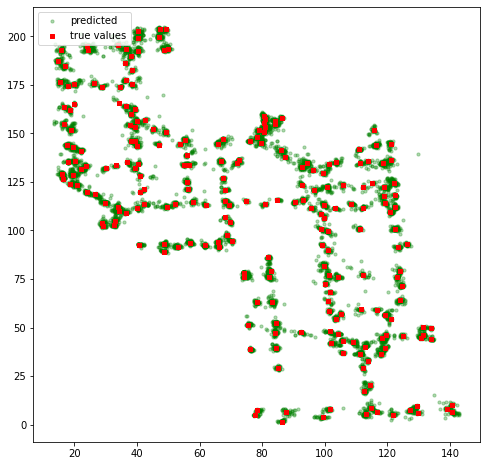

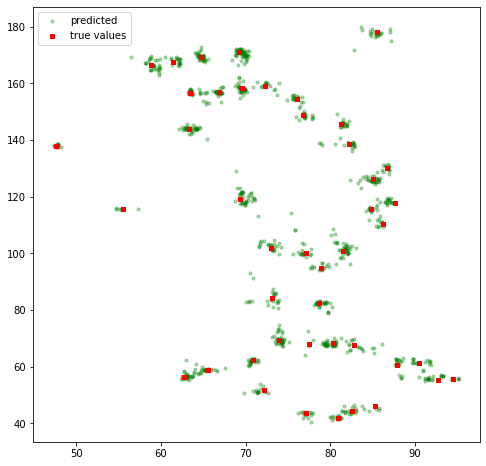

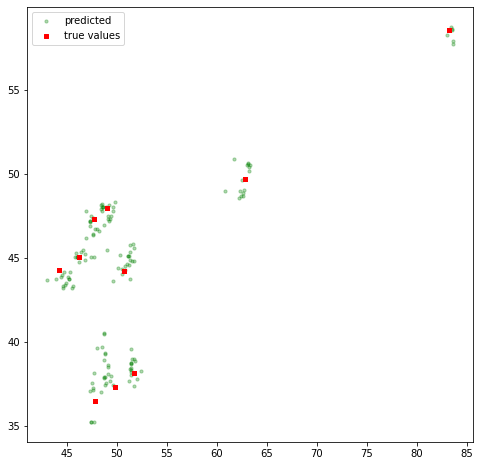

In [158]:
# Plot predictions against ground truths
df_viz_a = df_viz[df_viz["site_le_f"] == "site_9_floor_1"] # most counts

x = df_viz_a["x"]
y = df_viz_a["y"]
x_pred = df_viz_a["x_pred"]
y_pred = df_viz_a["y_pred"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(x_pred, y_pred, s=10, c="g", marker="o", label="predicted", alpha=0.3)
ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
plt.legend(loc='upper left');
plt.show()


df_viz_a = df_viz[df_viz["site_le_f"] == "site_6_floor_2"] # medium counts
x = df_viz_a["x"]
y = df_viz_a["y"]
x_pred = df_viz_a["x_pred"]
y_pred = df_viz_a["y_pred"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(x_pred, y_pred, s=10, c="g", marker="o", label="predicted", alpha=0.3)
ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
plt.legend(loc='upper left');
plt.show()


df_viz_a = df_viz[df_viz["site_le_f"] == "site_7_floor_0"] # second least counts
x = df_viz_a["x"]
y = df_viz_a["y"]
x_pred = df_viz_a["x_pred"]
y_pred = df_viz_a["y_pred"]

fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(x_pred, y_pred, s=10, c="g", marker="o", label="predicted", alpha=0.3)
ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
plt.legend(loc='upper left');
plt.show()


In [147]:
# Take difference of truth - predicted -> which has the largest difference
display(df_viz.head())
# print(df_viz["site_le_f"].value_counts())
df_viz_grouped = df_viz.groupby("site_le_f").agg({"site_le_f": ["count"], "x_diff": ["mean"], \
                                                  "y_diff": ["mean"], "f_diff": ["mean"], \
                                                  "metric": ["mean"]})
print(len(df_viz_grouped))
display(df_viz_grouped.head())

,site_id,ts,start_ts,diff_start_ts,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_500ms,within_1000ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,z_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
102,5da138764db8ce0c98bcaa46,1.571485e+12,1.571485e+12,9058.0,1.571485e+12,8871.0,187.0,True,True,1.571485e+12,9058.0,-0.727478,0.499908,13.413696,1.571485e+12,9058.0,0.027730,0.038320,-0.722747,1.571485e+12,9058.0,-27.142334,-6.182861,-26.126099,38.177312,1.571485e+12,9058.0,-0.518814,0.097382,0.214493,1571485320472,9058,0,0,13,1.571485e+12,9058.0,-19.424438,-2.775574,-382.04956,1571485320472,9058,0,0,0,1571485321093,9679,64f1125cb0e5e507a7ba5c32dd76bd506f30ce94,cfc730649716ef5c3303aff3b8694a3dba6867d2,-44,1571485320521,1571485320542,9128,07efd69e3167537492f0ead89fb2779633b04949_b6589...,-78,1.571485e+12,9119.0,1.444653,-0.048069,9,542,3,189,855,133,1571485320472000000,1571443200000000000,1571482800000000000,1571485320000000000,1571485320520999936,1571443200000000000,1571482800000000000,1571485320000000000,65.81377,144.757930,1,68.278139,145.070491,1.001274,1.001274,2.464369,0.312561,0.001274,site_9_floor_1,2.503219
56,5da138764db8ce0c98bcaa46,1.571479e+12,1.571479e+12,3639.0,1.571479e+12,4410.0,-771.0,False,True,1.571479e+12,3639.0,-0.640137,-0.572235,14.050476,1.571479e+12,3639.0,0.045085,0.030505,-0.725873,1.571479e+12,3639.0,-27.409363,-1.190185,-26.585388,38.203044,1.571479e+12,3639.0,-0.599319,-0.389664,-0.176682,1571478535695,3639,0,0,12,1.571479e+12,3639.0,-60.356140,-88.105774,-361.29913,1571478535695,3639,0,0,0,1571478534863,2807,64f1125cb0e5e507a7ba5c32dd76bd506f30ce94,88382398f776f89352a27da6d6ec3ee5abdf61b5,-52,1571478534676,1571478535751,3695,726388c292214e8a10ee4ae58707e9972ef10261_b6589...,-88,1.571479e+12,3719.0,1.356272,-0.116841,9,457,2,189,553,637,1571478535695000064,1571443200000000000,1571475600000000000,1571478480000000000,1571478534676000000,1571443200000000000,1571475600000000000,1571478480000000000,130.75407,115.990364,0,129.405332,116.152676,0.000106,0.000106,1.348738,0.162312,0.000106,site_9_floor_0,1.360052
602,5cdbc652853bc856e89a8694,1.561088e+12,1.561088e+12,77092.0,1.561088e+12,77322.0,-230.0,True,True,1.561088e+12,77092.0,-0.342178,-0.272781,9.946976,1.561088e+12,77092.0,0.017952,0.012406,-0.994121,1.561088e+12,77092.0,-13.080000,-28.500000,-27.240000,41.537381,1.561088e+12,77092.0,0.002167,0.009720,0.013260,1561088272059,77092,0,0,9,1.561088e+12,77092.0,42.600000,-52.920000,-85.08000,1561088272059,77092,0,0,0,1561088271877,76910,3f1cf24e44400da737a91a463587abb81badf546,ed27fae81c0287f0e26c183a9db2338fe48b1ae4,-73,1561088271559,1561088272143,77176,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-65,1.561088e+12,75803.0,0.143533,-0.611842,8,382,3,111,973,1018,1561088272059000064,1561075200000000000,1561086000000000000,1561088220000000000,1561088271559000064,1561075200000000000,1561086000000000000,1561088220000000000,131.15718,121.434510,1,131.036951,121.523932,0.998552,0.998552,0.120229,0.089422,0.001448,site_8_floor_1,0.171552
1108,5da138764db8ce0c98bcaa46,1.571541e+12,1.571541e+12,68345.0,1.571541e+12,67838.0,507.0,False,True,1.571541e+12,68345.0,-1.169235,-0.019638,7.779541,1.571541e+12,68345.0,0.055509,-0.003337,-0.696226,1.571541e+12,68345.0,-42.152405,-3.099060,-28.204346,50.812543,1.571541e+12,68345.0,-0.029221,-0.353287,0.96

43


,site_le_f,x_diff,y_diff,f_diff,metric
,count,mean,mean,mean,mean
site_le_f,,,,,
site_0_floor_0,850,0.567338,0.913234,0.006948,1.301664
site_0_floor_1,1442,0.525443,0.683899,0.003032,1.011337
site_0_floor_2,209,0.365244,0.413022,0.005018,0.686737
site_0_floor_3,157,0.213407,0.484557,0.000494,0.584941
site_1_floor_-1,1856,0.613001,0.594926,0.004574,1.024793


In [149]:
df_viz_grouped["x_diff"]["mean"]

site_le_f
site_0_floor_0     0.567338
site_0_floor_1     0.525443
site_0_floor_2     0.365244
site_0_floor_3     0.213407
site_1_floor_-1    0.613001
site_1_floor_-2    0.524347
site_1_floor_0     0.666882
site_2_floor_-1    0.519908
site_2_floor_-2    0.412041
site_2_floor_0     0.617858
site_2_floor_1     0.518619
site_3_floor_0     0.422165
site_3_floor_1     0.546337
site_3_floor_2     0.446685
site_3_floor_3     0.473486
site_3_floor_4     0.507786
site_3_floor_5     0.503380
site_4_floor_1     0.489829
site_4_floor_2     0.491416
site_5_floor_0     0.565285
site_5_floor_1     0.657238
site_5_floor_2     0.489114
site_5_floor_3     0.625836
site_5_floor_4     0.602722
site_6_floor_-1    0.543651
site_6_floor_0     0.603599
site_6_floor_1     0.508524
site_6_floor_2     0.546034
site_7_floor_0     0.528366
site_7_floor_1     0.692626
site_7_floor_2     0.607629
site_7_floor_3     0.397362
site_8_floor_-1    0.659518
site_8_floor_0     0.687005
site_8_floor_1     0.755364
site_8_flo

supposed_comp_metric:  1.050224837034398


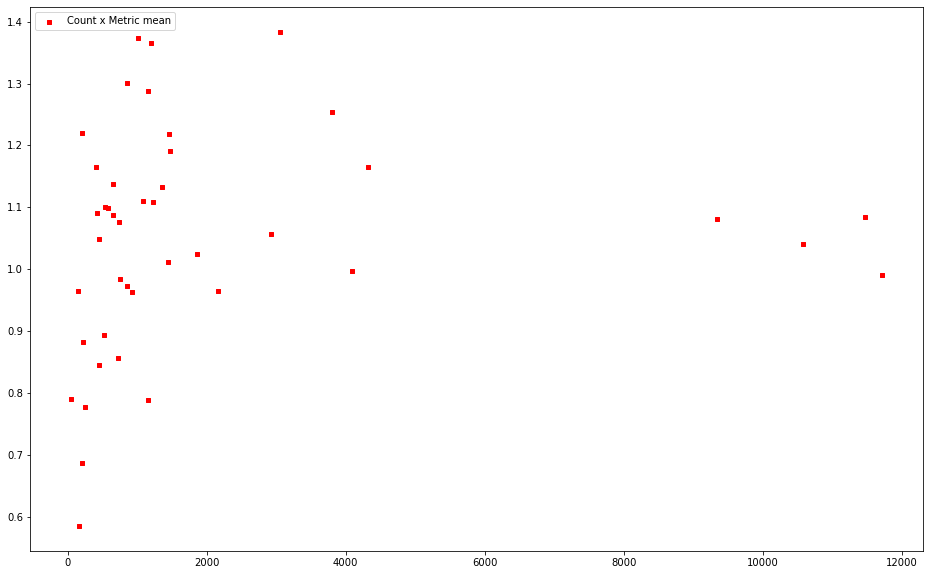

In [156]:
supposed_comp_metric = df_viz_grouped["metric"]["mean"].mean()
print("supposed_comp_metric: ", supposed_comp_metric)

# Visualize count and comp metric
a = df_viz_grouped["site_le_f"]["count"]
b = df_viz_grouped["metric"]["mean"]

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(a, b, s=10, c="r", marker="s", label="Count x Metric mean")
plt.legend(loc='upper left');
plt.show()

In [160]:
# Insights:
# You can't get below 1.0 even if you have loads of data with this model
# You need somewhere between 4000-9000 ish data for stable ~1.0 comp metric score
# We need to look at those data that score above 1.1

df_viz_above1_1 = df_viz_grouped[df_viz_grouped["metric"]["mean"] > 1.1]
print(len(df_viz_above1_1))
display(df_viz_above1_1)

16


,site_le_f,x_diff,y_diff,f_diff,metric
,count,mean,mean,mean,mean
site_le_f,,,,,
site_0_floor_0,850,0.567338,0.913234,0.006948,1.301664
site_1_floor_0,1477,0.666882,0.786575,0.002621,1.190520
site_2_floor_-1,1081,0.519908,0.780155,0.005611,1.109928
site_2_floor_0,1147,0.617858,0.903302,0.005731,1.287722
site_2_floor_1,651,0.518619,0.800229,0.005779,1.136950
site_5_floor_1,541,0.657238,0.676245,0.002248,1.100010
site_5_floor_3,199,0.625836,0.578260,0.019305,1.219953
site_6_floor_-1,1229,0.543651,0.781567,0.003045,1.109318


In [ ]:
with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [ ]:
print(len(df_test.columns))
# df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=0, how='any')
print(len(df_test.columns))

null_cols = df_test.columns[df_test.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_test, tqdm(null_cols), "site_id")

# null_cols = df_test.columns[df_test.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)


# column settings
# rename within_250ms and within_500ms first
# df_test = df_test.rename({"within_250ms": "within_100ms", "within_500ms": "within_200ms"}, axis=1)

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
categorical_features = ["site_id", "within_250ms", "within_500ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_test[col] = df_test[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_test[col] = df_test[col].astype(int)

# drop cols
drop_cols = ["file_id", "floor_le"]
df_test = df_test.drop(columns=drop_cols)
test_features = df_test.set_index("site_path_timestamp")

In [ ]:
print(len(df_test))
print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
display(test_features.head())
print(len(features.columns))
print(len(test_features.columns))
no_overlap = set(features.columns) ^ set(test_features.columns)
# a = list(set(features.columns) & set(test_features.columns))
print(no_overlap)
# print(features.dtypes[:50])
# print(test_features.dtypes[:50])

In [ ]:
# Load models
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
test_predsx = modelx.predict(test_features)
test_predsy = modely.predict(test_features)
test_predsf = modelf.predict(test_features)

In [ ]:
df_preds = pd.DataFrame(np.stack((test_features.index, test_predsf, test_predsx, test_predsy))).T
df_preds.columns = ["site_path_timestamp", "floor", "x", "y"]
# test_preds = test_preds.set_index("site_path_timestamp")
print("df_preds before groupby: ")
display(df_preds.head())

# groupby to take the average
# convert to float from object
for col in ["floor", "x", "y"]:
    df_preds[col] = df_preds[col].astype(float)

df_pred_grouped = df_preds.groupby(["site_path_timestamp"]).mean()
df_pred_grouped = df_pred_grouped.reset_index()

# round floor value to integer
df_pred_grouped["floor"] = df_pred_grouped["floor"].round(decimals=0)

print("len of df_pred_grouped: ", len(df_pred_grouped)) # should be same as sub_df length, but not yet
print("df_pred_grouped after groupby: ")
display(df_pred_grouped.head())

# find the missing site_path_timestamp and fill it with average
# get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
print("sub_df: ")
display(sub_df.head())

subdf_site_id = sub_df["site_path_timestamp"].unique()
pred_site_id = df_pred_grouped["site_path_timestamp"].unique()
print("len of subdf_site_id", len(subdf_site_id), "\n")
print("len of pred_site_id", len(pred_site_id), "\n")
no_overlap = set(subdf_site_id) ^ set(pred_site_id)
print("no overlap", no_overlap)

# missing timestamps -> fill in with average value for now
# '5dbc1d84c1eb61796cf7c010_67bf4b03fc22542bb6d51daf_0000000000011'
# '5d2709e003f801723c32d896_e3455e53350336857caf08f0_0000000119903'
floor_avg = round(df_pred_grouped["floor"].mean())
x_avg = df_pred_grouped["x"].mean()
y_avg = df_pred_grouped["y"].mean()
print("avg values for floor, x, y", floor_avg, x_avg, y_avg)

for i, ts in enumerate(list(no_overlap)):
    row = [ts, floor_avg, x_avg, y_avg]
    row_num = len(df_pred_grouped)
    df_pred_grouped.loc[row_num + i] = row

print("len of pred_grouped", len(df_pred_grouped))
print("tail of df_pred_grouped to check missing two rows are appended: ")
display(df_pred_grouped.tail())

In [ ]:
# csv for submission
df_pred_grouped.to_csv("submission.csv", index=False)